In [1]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import FacebookPagePage

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

## Model

In [2]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [3]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

## Cora

In [4]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

Processing...
Done!
/Users/kashyappatel/anaconda3/envs/gnnbctfd/lib/python3.12/site-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retu

In [5]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)

In [6]:
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.978 | Train Acc: 12.86% | Val Loss: 1.94 | Val Acc: 13.80%
Epoch  20 | Train Loss: 0.238 | Train Acc: 96.43% | Val Loss: 1.04 | Val Acc: 67.20%
Epoch  40 | Train Loss: 0.165 | Train Acc: 98.57% | Val Loss: 0.95 | Val Acc: 71.00%
Epoch  60 | Train Loss: 0.209 | Train Acc: 96.43% | Val Loss: 0.91 | Val Acc: 71.80%
Epoch  80 | Train Loss: 0.173 | Train Acc: 100.00% | Val Loss: 0.93 | Val Acc: 71.00%
Epoch 100 | Train Loss: 0.190 | Train Acc: 97.86% | Val Loss: 0.96 | Val Acc: 70.60%


In [7]:
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 81.00%


In [8]:
out = gat(data.x, data.edge_index)

In [9]:
degrees = degree(data.edge_index[0]).numpy()

In [10]:
accuracies = []
sizes = []

for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

In [11]:
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


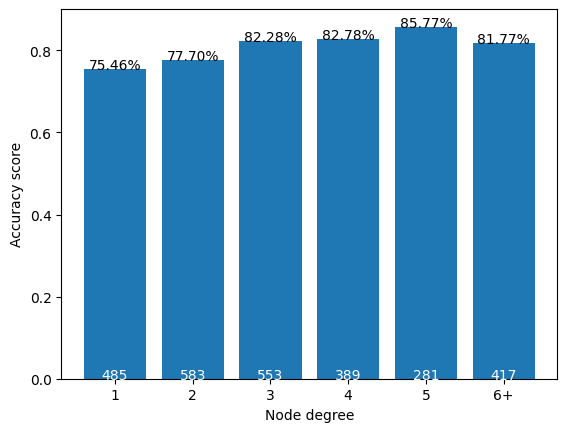

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

## Facebook

In [13]:
dataset = FacebookPagePage(root=".")
data = dataset[0]

Processing...
Done!


In [14]:
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

In [15]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat

GAT(
  (gat1): GATv2Conv(128, 32, heads=8)
  (gat2): GATv2Conv(256, 4, heads=1)
)

In [16]:
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.795 | Train Acc: 25.88% | Val Loss: 1.82 | Val Acc: 26.66%
Epoch  20 | Train Loss: 0.368 | Train Acc: 87.76% | Val Loss: 0.36 | Val Acc: 88.44%
Epoch  40 | Train Loss: 0.338 | Train Acc: 88.49% | Val Loss: 0.34 | Val Acc: 88.84%
Epoch  60 | Train Loss: 0.349 | Train Acc: 88.59% | Val Loss: 0.34 | Val Acc: 88.94%
Epoch  80 | Train Loss: 0.340 | Train Acc: 88.57% | Val Loss: 0.33 | Val Acc: 88.89%
Epoch 100 | Train Loss: 0.332 | Train Acc: 88.99% | Val Loss: 0.33 | Val Acc: 89.84%


In [17]:
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 91.25%


In [18]:
out = gat(data.x, data.edge_index)

In [19]:
degrees = degree(data.edge_index[0]).numpy()

In [20]:
accuracies = []
sizes = []

for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

In [21]:
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


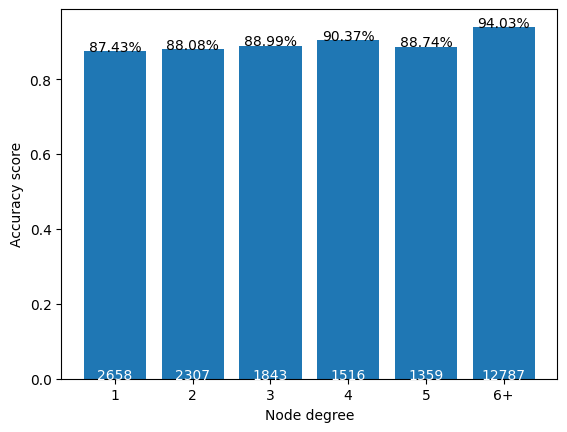

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')